# Kaggle Competition Dogs vs Cats Classification:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


_Competition link: https://www.kaggle.com/c/dogs-vs-cats/overview_

## Libraries:

In [2]:
import pandas as pd
import numpy as np
import os, shutil
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Conv2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Data Importation:

In [3]:
dir = '/content/drive/My Drive/Kaggle Dogs & Cats/Data'
original_dir = '/Users/spavot/Documents/Perso/Kaggle-Cat-vs-Dog-Classification/Data/Original_Data'
train_dir = os.path.join(dir, 'Training')
# os.mkdir(train_dir)
validation_dir = os.path.join(dir, 'Validation')
# os.mkdir(validation_dir)
test_dir = os.path.join(dir, 'Test')
# os.mkdir(test_dir)

In [4]:
#Training set directory
train_cats_dir = os.path.join(train_dir, 'Cats')
# os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'Dogs')
# os.mkdir(train_dogs_dir)
#Validation set directory
validation_cats_dir = os.path.join(validation_dir, 'Cats')
# os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'Dogs')
# os.mkdir(validation_dogs_dir)
#Test set directory
test_cats_dir = os.path.join(test_dir, 'Cats')
# os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'Dogs')
# os.mkdir(test_dogs_dir)

In [5]:
# #Copy the image to the right directory:
# fnames = ['cat.{}.jpg'.format(i) for i in range(8000)]
# for fname in fnames:
#     src = os.path.join(original_dir, fname)
#     dst = os.path.join(train_cats_dir, fname)
#     shutil.copyfile(src,dst)
# #Dogs images:
# fnames = ['dog.{}.jpg'.format(i) for i in range(8000)]
# for fname in fnames:
#     src = os.path.join(original_dir, fname)
#     dst = os.path.join(train_dogs_dir, fname)
#     shutil.copyfile(src,dst)

In [6]:
# #Copy the image to the validation directory:
# #Cats images
# fnames = ['cat.{}.jpg'.format(i) for i in range(8000,10500)]
# for fname in fnames:
#     src = os.path.join(original_dir, fname)
#     dst = os.path.join(validation_cats_dir, fname)
#     shutil.copyfile(src,dst)
# #Dogs images:
# fnames = ['dog.{}.jpg'.format(i) for i in range(8000,10500)]
# for fname in fnames:
#     src = os.path.join(original_dir, fname)
#     dst = os.path.join(validation_dogs_dir, fname)
#     shutil.copyfile(src,dst)

In [7]:
# #Copy the image to the test directory:
# #Cats images
# fnames = ['cat.{}.jpg'.format(i) for i in range(10500,12500)]
# for fname in fnames:
#     src = os.path.join(original_dir, fname)
#     dst = os.path.join(test_cats_dir, fname)
#     shutil.copyfile(src,dst)
# #Dogs images:
# fnames = ['dog.{}.jpg'.format(i) for i in range(10500,12500)]
# for fname in fnames:
#     src = os.path.join(original_dir, fname)
#     dst = os.path.join(test_dogs_dir, fname)
#     shutil.copyfile(src,dst)

In [8]:
#Check if we have the correct number of pictures per set:
print('Total training set cats:', len(os.listdir(train_cats_dir)))
print('Total training set dogs:', len(os.listdir(train_dogs_dir)))
print('Total validation set cats:', len(os.listdir(validation_cats_dir)))
print('Total validation set dogs:', len(os.listdir(validation_dogs_dir)))
print('Total test set cats:', len(os.listdir(test_cats_dir)))
print('Total test set dogs:', len(os.listdir(test_dogs_dir)))

Total training set cats: 8000
Total training set dogs: 8000
Total validation set cats: 2510
Total validation set dogs: 2500
Total test set cats: 2000
Total test set dogs: 2000


As expected, we have 8000 training samples of each class, 2000 for validation set and finally 2500 for the testing set to confirm the results and avoid overfitting on the validation set.

## Data preprocessing:

In [9]:
#Because we have a lot of data, we won't load them and instead use a generator:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 50

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    color_mode = 'rgb',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 16000 images belonging to 2 classes.
Found 5010 images belonging to 2 classes.


In [10]:
#Sanity check:
for data, labels in train_generator:
    print(data.shape)
    print(labels.shape)
    break
for data, labels in validation_generator:
    print(data.shape)
    print(labels.shape)
    break

(50, 150, 150, 3)
(50,)
(50, 150, 150, 3)
(50,)


Seems to be as we wanted, we have our generators ready!

## Modeling using Keras and CNN layers:

First we will create callbacks to save the model and stop it when it start overfitting. Note that we use accuracy as the metric as our classes are equally distributed.

In [11]:
Model_Name = ''
callback = [EarlyStopping(monitor='val_accuracy', patience=3), ModelCheckpoint(filepath = '/Users/spavot/Documents/Perso/Kaggle-Cat-vs-Dog-Classification/Models/'+ Model_Name, monitor = 'val_accuracy', save_best_only = True)]

## Own build model:

In [12]:
#Assign the variable to a name for saving the best model
Model_Name = 'Own_1st_Model_CNN.h5'
#Build the model
own_model = Sequential()
own_model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
own_model.add(MaxPooling2D((2,2)))
own_model.add(Conv2D(32, (3,3), activation = 'relu'))
own_model.add(MaxPooling2D((2,2)))
own_model.add(Conv2D(32, (3,3), activation = 'relu'))
own_model.add(MaxPooling2D((2,2)))
own_model.add(Flatten())
own_model.add(Dropout(0.5))
own_model.add(Dense(512, activation = 'relu'))
own_model.add(Dense(1, activation = 'sigmoid'))
#Compile the model
own_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#Print the summary of the model
own_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0

In [13]:
#Initiate a callback to stop when the model start overfitting, we do not use checkpoint save as it can crash with Google Colab
callback = EarlyStopping(monitor='val_accuracy', patience=3)
#Fit the model using train_generator for training and validation_generator for testing
history = own_model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_steps = validation_generator.samples//validation_generator.batch_size,
    callbacks = [callback],
    verbose = 1)

Epoch 1/30
320/320 [==============================] - 3826s 12s/step - loss: 0.6509 - accuracy: 0.6101 - val_loss: 0.5810 - val_accuracy: 0.6780
Epoch 2/30
320/320 [==============================] - 451s 1s/step - loss: 0.5564 - accuracy: 0.7132 - val_loss: 0.5231 - val_accuracy: 0.7500
Epoch 3/30
320/320 [==============================] - 456s 1s/step - loss: 0.5063 - accuracy: 0.7494 - val_loss: 0.4646 - val_accuracy: 0.7826
Epoch 4/30
320/320 [==============================] - 452s 1s/step - loss: 0.4634 - accuracy: 0.7824 - val_loss: 0.4399 - val_accuracy: 0.7906
Epoch 5/30
320/320 [==============================] - 451s 1s/step - loss: 0.4162 - accuracy: 0.8064 - val_loss: 0.4263 - val_accuracy: 0.8036
Epoch 6/30
320/320 [==============================] - 452s 1s/step - loss: 0.3767 - accuracy: 0.8309 - val_loss: 0.3901 - val_accuracy: 0.8214
Epoch 7/30
320/320 [==============================] - 456s 1s/step - loss: 0.3250 - accuracy: 0.8570 - val_loss: 0.4025 - val_accuracy: 0.81

In [14]:
#Save the model
own_model.save('/content/drive/My Drive/Kaggle Dogs & Cats/Models/OwnV3.h5')

In [15]:
#Plot the loss evolution for training / validation sets
epochs = np.arange(1, len(history.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history.history['loss']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history.history['val_loss']))
fig.update_layout(
    title="Training & Validation loss evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

In [16]:
#Plot the accuracy evolution for training / validation sets
epochs = np.arange(1, len(history.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history.history['accuracy']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history.history['val_accuracy']))
fig.update_layout(
    title="Training & Validation accuracy evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

Our model seems to overfit very fast, we will try to use data augmentation. This technique help to regularize the model and improve performance by changing a little bit the data so the model won't see twice the same image when training.

In [8]:
#Create an augmented generator
Aug_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [9]:
#Get the path of a randomly selected image
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
img = load_img(fnames[7], target_size = (150,150))

In [10]:
#Transform image to array and reshape it to (1,150,150,3)
cat_img = img_to_array(img)
cat_img = cat_img.reshape((1,) + cat_img.shape)

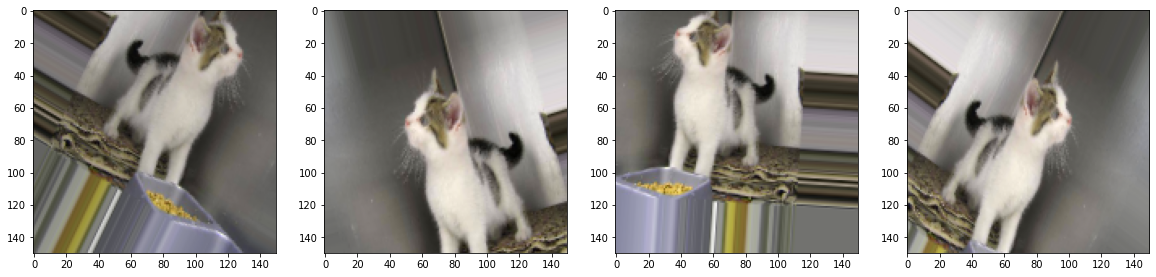

In [11]:
#Plot only four version of the image:
x = 0
f, axarr = plt.subplots(1,4, figsize=(20,30))
for i in Aug_datagen.flow(cat_img, batch_size = 1):
    axarr[x].imshow(array_to_img(i[0]))
    x += 1
    if x % 4 == 0:
        break
plt.show()

Now that we seen what augmented generator does, let's apply it to our model to improve the accuracy.

In [12]:
#Initiate new generators:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

#Initiate test generator with only rescale parameter (for test we don't want to modify the data)
test_datagen = ImageDataGenerator(rescale = 1./255)

#Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 50,
    class_mode = 'binary'
)
#Validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 50,
    class_mode = 'binary'
)
#Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 50,
    class_mode = 'binary'
)

Found 16000 images belonging to 2 classes.
Found 5010 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [22]:
#Assign the variable to a name for saving the best model
Model_Name = 'Own_2nd_Model_CNN.h5'
#Build the model
own_model_aug = Sequential()
own_model_aug.add(Conv2D(32,(3,3), activation = 'relu', input_shape = (150,150,3)))
own_model_aug.add(MaxPooling2D((2,2)))
own_model_aug.add(Conv2D(32, (3,3), activation = 'relu'))
own_model_aug.add(MaxPooling2D((2,2)))
own_model_aug.add(Conv2D(32, (3,3), activation = 'relu'))
own_model_aug.add(MaxPooling2D((2,2)))
own_model_aug.add(Flatten())
own_model_aug.add(Dropout(0.5))
own_model_aug.add(Dense(512, activation = 'relu'))
own_model_aug.add(Dense(1, activation = 'sigmoid'))
#Compile the model
own_model_aug.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#Print the summary of the model
own_model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)             

In [23]:
#Initiate a callback to stop when the model start overfitting, we do not use checkpoint save as it can crash with Google Colab
callback = EarlyStopping(monitor='val_accuracy', patience=3)
#Fit the model using train_generator for training and validation_generator for testing
history_augmented = own_model_aug.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_steps = validation_generator.samples//validation_generator.batch_size,
    callbacks = [callback],
    verbose = 1)

Epoch 1/30
320/320 [==============================] - 520s 2s/step - loss: 0.6844 - accuracy: 0.5460 - val_loss: 0.6159 - val_accuracy: 0.6404
Epoch 2/30
320/320 [==============================] - 516s 2s/step - loss: 0.6333 - accuracy: 0.6413 - val_loss: 0.5899 - val_accuracy: 0.6840
Epoch 3/30
320/320 [==============================] - 508s 2s/step - loss: 0.6007 - accuracy: 0.6739 - val_loss: 0.5438 - val_accuracy: 0.7264
Epoch 4/30
320/320 [==============================] - 513s 2s/step - loss: 0.5763 - accuracy: 0.6943 - val_loss: 0.5268 - val_accuracy: 0.7354
Epoch 5/30
320/320 [==============================] - 515s 2s/step - loss: 0.5607 - accuracy: 0.7099 - val_loss: 0.5165 - val_accuracy: 0.7414
Epoch 6/30
320/320 [==============================] - 508s 2s/step - loss: 0.5399 - accuracy: 0.7270 - val_loss: 0.5121 - val_accuracy: 0.7464
Epoch 7/30
320/320 [==============================] - 510s 2s/step - loss: 0.5361 - accuracy: 0.7289 - val_loss: 0.4506 - val_accuracy: 0.7818

In [24]:
#Save the model
own_model.save('/content/drive/My Drive/Kaggle Dogs & Cats/Models/Own_Aug_V3.h5')

In [25]:
#Plot the loss evolution for training / validation sets
epochs = np.arange(1, len(history_augmented.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history_augmented.history['loss']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history_augmented.history['val_loss']))
fig.update_layout(
    title="Training & Validation loss evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

In [26]:
#Plot the accuracy evolution for training / validation sets
epochs = np.arange(1, len(history_augmented.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history_augmented.history['accuracy']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history_augmented.history['val_accuracy']))
fig.update_layout(
    title="Training & Validation accuracy evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

We improved the model performance but we can do better. Unfortunately, stuck with not big computational power and a low sample of training images, we might not achieve way better for this classification. To improve our performance, we will use a pretrain model on a big dataset of millions of images and use this one for our competition. What we will do is freeze the first layers that contain the global information and let this new model only train the last layers. As it has been trained to detect images and animals, the global pattern can stay frozen where the deeper layers needs to be updated for our specific usecase.

## Pretrained Model:

Note that we will still use augmented data for our pretrained model as it increases performance and regularize the model.

### Freeze all the imported model:

For the first part, we will completely freeze the model imported and just let the two dense layers we will add being able to be trained.

In [14]:
#Download the pretrain model
pretrain_base = VGG16(weights = 'imagenet',
                       include_top = False,
                       input_shape = (150,150,3))
#Print the summary of this model
pretrain_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

It is a way bigger network with this time 14 millions of parameters, training all of them would take a long time and not be usefull as we want to use the weights already pretrain for our problem. Note that we didn't took the include_top as it contains a dense layer of 1000 possible outputs where we only want 2 possible outputs so let's finish the model.

In [15]:
#Freeze the pretrain part of the model
pretrain_base.trainable = False
#Add flatten, densely connected and output layers:
pretrain_model = Sequential()
pretrain_model.add(pretrain_base)
pretrain_model.add(Flatten())
pretrain_model.add(Dense(512, activation = 'relu'))
pretrain_model.add(Dense(1, activation = 'sigmoid'))

#Compile the model
pretrain_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#Print the summary of the new model
pretrain_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


We now have 18 millions of parameters, thankfully, we froze the pretrain model. We can see that only 4 millions of parameters are now trainable.

In [18]:
#Initiate a callback to stop when the model start overfitting, we do not use checkpoint save as it can crash with Google Colab
callback = EarlyStopping(monitor='val_accuracy', patience=3)
#Fit the model using train_generator for training and validation_generator for testing
history_pretrain = pretrain_model.fit(
    train_generator,
    epochs = 3,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_steps = validation_generator.samples//validation_generator.batch_size,
    callbacks = [callback],
    verbose = 1)

Epoch 1/3
320/320 [==============================] - 4825s 15s/step - loss: 0.4335 - accuracy: 0.8100 - val_loss: 0.2430 - val_accuracy: 0.9010
Epoch 2/3
320/320 [==============================] - 4653s 15s/step - loss: 0.3302 - accuracy: 0.8535 - val_loss: 0.2577 - val_accuracy: 0.8920
Epoch 3/3
320/320 [==============================] - 4624s 14s/step - loss: 0.3216 - accuracy: 0.8583 - val_loss: 0.2258 - val_accuracy: 0.9060


In [19]:
#Save the model
pretrain_model.save('/content/drive/My Drive/Kaggle Dogs & Cats/Models/pre_trainable.h5')

In [20]:
#Plot the loss evolution for training / validation sets
epochs = np.arange(1, len(history_pretrain.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history_pretrain.history['loss']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history_pretrain.history['val_loss']))
fig.update_layout(
    title="Training & Validation loss evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

In [22]:
#Plot the accuracy evolution for training / validation sets
epochs = np.arange(1, len(history_pretrain.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history_pretrain.history['accuracy']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history_pretrain.history['val_accuracy']))
fig.update_layout(
    title="Training & Validation accuracy evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

### Unfreeze the last 3 layers of the pretrain model:

In [ ]:
#Download the pretrain model
pretrain_base = VGG16(weights = 'imagenet',
                       include_top = False,
                       input_shape = (150,150,3))
#Print the summary of this model
pretrain_base.summary()

We want to unfreeze the layers from block5_conv1:

In [ ]:
#Make the last 3 layers trainable
pretrain_base.trainable = True
set_trainable = False
#For loop to unfreeze the last 3 layers
for layer in pretrain_base.layers:
    #When we reach the first layer, set_trainable becomes true
    if layer.name == 'block5_conv1':
        set_trainable = True
    #So from this point, when set_trainable is true, the layer is changed to be able to be trained
    if set_trainable:
        layer.trainable = True
    #Before we reach the first layer mentionned above, the layers are switch to be unfreeze
    else:
        layer.trainable = False

In [ ]:
#Check the summary again
pretrain_base.summary()

We now see that we have 7 millions parameters trainable which corresponds to the last 3 layers, let's build our model again:

In [ ]:
#Add flatten, densely connected and output layers:
pretrain_trainable_model = Sequential()
pretrain_trainable_model.add(pretrain_base)
pretrain_trainable_model.add(Flatten())
pretrain_trainable_model.add(Dense(512, activation = 'relu'))
pretrain_trainable_model.add(Dense(1, activation = 'sigmoid'))

#Initiate an optimizer
opti = Adam(lr = 0.00001)
#Compile the model this time using a very low learning rate to don't change totally the last layers weights
pretrain_model.compile(loss = 'binary_crossentropy', optimizer = opti, metrics = ['accuracy'])

#Print the summary of the new model
pretrain_trainable_model.summary()

We now have 11 millions trainable parameters compared to 4 millions previously with the total frozen model.

In [ ]:
#Initiate a callback to stop when the model start overfitting, we do not use checkpoint save as it can crash with Google Colab
callback = EarlyStopping(monitor='val_accuracy', patience=3)
#Fit the model using train_generator for training and validation_generator for testing
history_pretrain_trainable = pretrain_trainable_model.fit(
    train_generator,
    epochs = 3,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    validation_steps = validation_generator.samples//validation_generator.batch_size,
    callbacks = [callback],
    verbose = 1)

In [ ]:
#Save the model
pretrain_trainable_model.save('/content/drive/My Drive/Kaggle Dogs & Cats/Models/pre_trainable.h5')

In [ ]:
#Plot the loss evolution for training / validation sets
epochs = np.arange(1, len(history_pretrain_trainable.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history_pretrain_trainable.history['loss']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history_pretrain_trainable.history['val_loss']))
fig.update_layout(
    title="Training & Validation loss evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

In [ ]:
#Plot the accuracy evolution for training / validation sets
epochs = np.arange(1, len(history_pretrain_trainable.history['loss'])+1)
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'Training set', x = epochs, y = history_pretrain_trainable.history['accuracy']))
fig.add_trace(go.Scatter(name = 'Validation set', x = epochs, y = history_pretrain_trainable.history['val_accuracy']))
fig.update_layout(
    title="Training & Validation accuracy evolution",
    xaxis_title="Epochs",
    yaxis_title="Loss")

## Visualize what the models learned:

Convolutionnal model are models that are not black box. We can run the inverse process of training the model to get the a visual of what each convolutionnal layer learned and so understand what it represent within an image.

To do so, we will first load the model we trained previously in Google Colab Cloud as our computer was not enough powerfull to handle them.

In [ ]:
#Load first model:
own_model = load_model('/Users/spavot/Documents/Perso/Kaggle-Cat-vs-Dog-Classification/Models/own_model.h5')

We first laod an image from the validation set (so the model didn't trained on it):

In [ ]:
img_path = os.path.join(validation_dir, 'Cats/cat.8501.jpg')
img = load_img(img_path, target_size = (150,150))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

print(img_tensor.shape)

In [ ]:
#Print the image
plt.imshow(img_tensor[0])
plt.show()

Let's now visualize every channel in every intermediate layers:

In [ ]:
#First display a summary of the model:
own_model.summary()

In [ ]:
#Initiate an array of layers name
layers_name = []
for layer in own_model.layers[:6]:
    layers_name.append(layer.name)
print(layers_name)

In [ ]:
layers_outputs = [layer.output for layer in own_model.layers[:6]]
activation_model = Model(inputs = own_model.input, outputs = layers_outputs)
activations = activation_model.predict(img_tensor)

We only have the convolutionnal layers as expected, let's create a function now to visualiza their activations for every channels:

In [ ]:
def visualize_activation(layers_name, activations, images_per_row):
    for layer_name, layer_activation in zip(layers_name, activations):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features // images_per_row
        display_grid = np.zeros((size*n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image +=128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1)* size] = channel_image
        scale = 1. / size
        plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [ ]:
visualize_activation(layers_name, activations, 16)